# CNN GAN for MNIST (PyTorch)
Sam Greydanus. 23 April 2017. MIT License.

In [1]:
% matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from torchvision import datasets, models, transforms, utils
import numpy as np
import matplotlib.pyplot as plt
import os

## Hyperparameters

In [2]:
batch_size = 64
G_lr = D_lr = 1e-3
global_step = 0
print_every = 1000
total_steps = 10000
cost_func = nn.BCELoss()

D_ent = 100
D_side = 28
D_img = D_side**2
D_hidden = 128

## Dataloader

In [3]:
modes = ['train', 'val']
trans = transforms.Compose([transforms.ToTensor(),]) # transforms.Normalize((0.1307,), (0.3081,))
dsets = {k: datasets.MNIST('./data', train=k=='train', download=True, transform=trans) for k in modes}
loaders = {k: torch.utils.data.DataLoader(dsets[k], batch_size=batch_size, shuffle=True) for k in modes}

def entropy():
    return Variable(torch.randn(batch_size, D_ent))

def mnist():
    data = next(iter(loaders['train']))[0]
    return Variable(data).resize(batch_size, D_img)

## Inspect data

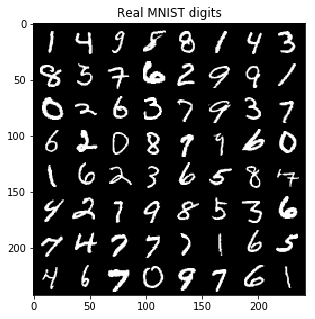

In [4]:
def imshow(inp, c, save=False, title=None):
    """Imshow for Tensor."""
    fig = plt.figure(figsize=(5, 5))
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    
    plt.title(title) if title is not None else plt.title(str(c).zfill(3))
    if save:
        if not os.path.exists('cnn-out/'):
            os.makedirs('cnn-out/')
        plt.savefig('cnn-out/{}.png'.format(str(c).zfill(3)), bbox_inches='tight')
        plt.close(fig)

inputs = mnist().data.resize_(batch_size,1,D_side,D_side)
out = utils.make_grid(inputs)
imshow(out, c=0, save=False, title="Real MNIST digits")

## Build the discriminator (D) and generator (G) models

In [ ]:
# a generic CNN for MNIST, see github.com/pytorch/examples/blob/master/mnist/main.py
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 1)

    def forward(self, x):
        x = x.resize(batch_size,1,D_side,D_side)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.sigmoid(x)
    
# a vanilla neural network with one hidden layer
class SimpleNN(torch.nn.Module):
    def __init__(self, batch_size, input_dim, h_dim, output_dim):
        super(SimpleNN, self).__init__()
        self.W1 = nn.Parameter(torch.randn(input_dim, h_dim)*0.075)
        self.b1 = nn.Parameter(torch.randn(h_dim)*0.075)
        self.W2 = nn.Parameter(torch.randn(h_dim, output_dim)*0.075)
        self.b2 = nn.Parameter(torch.randn(output_dim)*0.075)

    def forward(self, X):
        h = F.relu(X.mm(self.W1) + self.b1.repeat(X.size(0), 1))
        return F.sigmoid(h.mm(self.W2) + self.b2.repeat(X.size(0), 1))
    
D = SimpleCNN()
G = SimpleNN(batch_size, D_ent, D_hidden, D_img)

## Train adversarially
Takes ~30 min to train on my MacBook

In [ ]:
optimizers = {'D': torch.optim.Adam(D.parameters(), lr=D_lr),
              'G': torch.optim.Adam(G.parameters(), lr=G_lr)}
ones_label = Variable(torch.ones(batch_size))
zeros_label = Variable(torch.zeros(batch_size))

# generic train loop
for global_step in range(global_step, total_steps+global_step):
    
    # ======== DISCRIMINATOR STEP ======== #
    # forward
    z = entropy() ; X = mnist()
    G_sample = G(z)
    D_real = D(X)
    D_fake = D(G_sample)

    # backward
    D_loss_real = cost_func(D_real, ones_label)
    D_loss_fake = cost_func(D_fake, zeros_label)
    D_loss = D_loss_real + D_loss_fake
    D_loss.backward()
    optimizers['D'].step()
    [o.zero_grad() for o in optimizers.values()]
    
    # ======== GENERATOR STEP ======== #
    # forward
    z = entropy()
    G_sample = G(z)
    D_fake = D(G_sample)
    
    # backward
    G_loss = cost_func(D_fake, ones_label)
    G_loss.backward()
    optimizers['G'].step()
    [o.zero_grad() for o in optimizers.values()]

    # ======== DISPLAY PROGRESS ======== #
    if global_step % print_every == 0:
        print('step {}: D loss: {:.4f}; G loss: {:.4f}'
              .format(global_step, D_loss.data.numpy()[0], G_loss.data.numpy()[0]))
        
        samples = G(entropy()).data.resize_(batch_size,1,D_side,D_side)
        samples = utils.make_grid(samples)
        imshow(samples, c = global_step // print_every, save=True)

step 0: D loss: 1.3656; G loss: 0.7058
step 1000: D loss: 0.0275; G loss: 6.5377
step 2000: D loss: 0.3350; G loss: 3.9516
step 3000: D loss: 0.1815; G loss: 4.3599
step 4000: D loss: 0.0937; G loss: 5.0155


## Inspect results

In [ ]:
samples = G(entropy()).data.resize_(batch_size,1,D_side,D_side)
samples = utils.make_grid(samples)
imshow(samples, c = global_step // print_every, save=False,
       title="Fake MNIST digits ({} train steps)".format(global_step))